# 設定
1. Set parameters in `set_params.py`
2. Put it in `data_dir`

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lorenz96_cython import rk4_cython
from lorenz96_cython import lorenz96_cython
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF
import visualize as vis

In [46]:
data_dir = "data/r4"
import os

# Define the function to load the module
def load_module(path_str):
    import importlib.util

    # Construct the path to the set_params.py file
    params_path = os.path.join(path_str, 'set_params.py')

    # Load the module
    spec = importlib.util.spec_from_file_location("set_params", params_path)
    set_params = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(set_params)

    return set_params

# Use the function to load the parameters
set_params = load_module(data_dir)

# Access the parameters
J = set_params.J
F = set_params.F
dt = set_params.dt
N = set_params.N
obs_per = set_params.obs_per
Nt = set_params.Nt
T_inf = set_params.T_inf
r = set_params.r
N_spinup = set_params.N_spinup
m_reduced_list = set_params.m_reduced_list
alpha_list = set_params.alpha_list
seeds = set_params.seeds

# print params
# TODO: make function to print params
print(f"Number of variables: {J}")
print(f"Model parameter F: {F}")
print(f"Time step size: {dt}")
print(f"Number of time steps for nature run: {N}")
print(f"Number of time steps per which observations are obtatined: {obs_per}")
print(f"Number of time steps for OSSE: {Nt}")
print(f"Length of the spin-up period: {N_spinup}")
print(f"Length of the assimilation window: {T_inf}")
print(f"Std. of observation noise: {r}")
print(f"List of number of ensemble members: {m_reduced_list}")
print(f"List of inflation factors: {alpha_list}")
print(f"List of random seeds: {seeds}")

Number of variables: 40
Model parameter F: 8
Time step size: 0.01
Number of time steps for nature run: 151200
Number of time steps per which observations are obtatined: 5
Number of time steps for OSSE: 28800
Length of the spin-up period: 500
Length of the assimilation window: 500
Std. of observation noise: 0.0001
List of number of ensemble members: [12, 13, 14, 15, 16, 17, 18]
List of inflation factors: [1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3]
List of random seeds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Lorenz 96
$ J = 40 $, $ F = 8 $のとき，positive-neutral Lyapunov exponentは14個

In [47]:
print("(J, F):", (J, F))

(J, F): (40, 8)


### Generate test data

In [48]:
# generate data
# dt: time step size
# dt = 0.
print(f"dt: {dt}")

# N: number of time step, 1 year : 360*20
assert N > 360*20
print(f"N: {N}")

# initial state near the statinary point
x0 = F*np.ones(J) # the statinary point
x0[19] *= 1.001 # perturb

# use my modules
scheme = rk4_cython
# p = (F, )
p = (np.ones(J)*F,)

result = np.zeros((N,len(x0)))
x = x0
result[0] = x[:]

for n in range(1,N):
    t = n*dt
    # x = scheme(lorenz96, t, x, p, dt) # without using cython
    x = scheme(lorenz96_cython, t, x, *p, dt)
    result[n] = x[:]

# save the result
x_true = result[360*20:][::obs_per] # spin up 1 year and save per 6 hours
print(x_true.shape)
np.save(f"{data_dir}/x_true_l96", x_true)

dt: 0.01
N: 151200
(28800, 40)


## DA setting

In [49]:
# assimilation period
Dt = obs_per*dt

# Model function for EnKF
# def M(x, Dt):
#     for _ in range(int(Dt/dt)):
#         x = rk4(lorenz96, 0, x, p, dt)
#     return x

def M_cython(x, Dt):
    for _ in range(int(Dt/dt)):
        x = rk4_cython(lorenz96_cython, 0, x, *p, dt)
    return x

# 観測
H_diag = np.ones(J)
H = np.diag(H_diag)
print("diag of H:", H_diag)
print("rank(H):", np.linalg.matrix_rank(H))

# Model error covariance
Q = np.zeros((J, J))

# Observation error covariance
print("r:", r)
R = r**2*np.eye(J)


# generate observation
print("Nt:", Nt)
x_true = np.load(f'{data_dir}/x_true_l96.npy')[:Nt]
print("x_true.shape", x_true.shape)

# ensemble size
m = J+1

# initial state for EnKF
# x_0 = x_true[np.random.randint(len(x_true)-1)]

# # random ensemble
# P_0 = 25*np.eye(J)
# X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)

# # deterministic ensemble
# X_0 = np.zeros((m, J))
# for i in range(m):
#     if i == J:
#        e = X_0[:J].sum(axis=0)
#        X_0[J] = e
#     else:
#         e = np.zeros(J)
#         e[i] = 1
#         X_0[i] = e
# X_0 *= 1

# inflation
# alpha = 1.2

diag of H: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rank(H): 40
r: 0.0001
Nt: 28800
x_true.shape (28800, 40)


## ETKF with ensemble reduction
To see that "good" initial ensemble and accurate observation provide stably accurate state estimation.
(Motived by Tokman-Hunt 2013)

Assume extremely accurate observation.
1. Assimilate until `N_spinup` time with large ensemble.
2. After ensemble mean reaches to the truth, reduce ensemble using SVD.

In [50]:
def reduce_by_svd(X, m_reduced):
    # m, Nx = X.shape
    xmean = X.mean(axis=0)
    dX = X - xmean[None, :]
    U, S, Vh = np.linalg.svd(dX.T)
    # print(dX.T.shape, U.shape, Vh.shape)
    # dX_reduced = np.matmul(U[:, :m_reduced], np.diag(S[:m_reduced])@Vh[:m_reduced, :m_reduced])
    dX_reduced = U[:, :m_reduced]@np.diag(S[:m_reduced]) # principal components
    X_reduced = xmean[None, :] + dX_reduced.T
    return X_reduced

def reduce_by_sample(X, m_reduced):
    m, _ = X.shape
    return X[np.random.choice(m, m_reduced)]

In [51]:
# RUN OSSE with small ensemble
# etkf0_list = []
# for m_reduced in m_reduced_list:
#     X_reduced = reduce_by_svd(X_0, m_reduced)
#     # X_reduced = reduce_by_sample(X_0, m_reduced)
#     etkf0 = ETKF(M, H, R, alpha=alpha, store_ensemble=True)
#     etkf0.initialize(X_reduced)
#     for y_obs in y:
#         etkf0.forecast(Dt)
#         etkf0.update(y_obs)

#     X_a = etkf0.X_a
#     print(X_a[0].shape, X_a[-1].shape)
#     etkf0_list.append(etkf0)

In [52]:
# RUN OSSE first with large ensemble, then reduce ensemble size
# # loop for m
# etkf_list = []
# for m_reduced in m_reduced_list:
#     etkf = ETKF(M, H, R, alpha=alpha, store_ensemble=True)
#     etkf.initialize(X_0)
#     for y_obs in y[:N_spinup]:
#         etkf.forecast(Dt)
#         etkf.update(y_obs)

#     # reduce ensemble
#     X_reduced = reduce_by_svd(etkf.X, m_reduced)
#     # X_reduced = reduce_by_sample(etkf.X, m_reduced)
#     etkf.initialize(X_reduced)
#     # etkf.alpha = 1.0
#     for y_obs in y[N_spinup:]:
#         etkf.forecast(Dt)
#         etkf.update(y_obs)

#     X_a = etkf.X_a
#     print(X_a[0].shape, X_a[-1].shape)
#     etkf_list.append(etkf)

In [53]:
# RUN OSSE first with large ensemble, then reduce ensemble size
# loop for m
# 70min

etkf_list = []
param_dict = {}
filename = data_dir + "/{}-{}{}{}"

# loop length
print(f"{len(m_reduced_list)*len(alpha_list)*len(seeds)} loops")
for i, m_reduced in enumerate(m_reduced_list):
    for j, alpha in enumerate(alpha_list):
        for k, seed in enumerate(seeds):
            param_dict[(i,j,k)] = (m_reduced, alpha, seed)
            try:
                Xa = np.load(filename.format("xa", i, j, k) + ".npy")
                print(filename.format("xa", i, j, k) + ".npy loaded" )
                print("Xa.shape", Xa.shape)
            except:
                print(i, j, k)
                
                np.random.seed(seed)
                # generate obs
                y = (H@x_true.T).T
                y += np.random.normal(loc=0, scale=r, size=y.shape) # R = r^2*I
                
                # generate initial ensemble
                x_0 = x_true[np.random.randint(len(x_true)-1)]
                P_0 = 25*np.eye(J)
                X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x) 
                
                # run spin-up
                print("spin-up")
                etkf = ETKF(M_cython, H, R, alpha=alpha, store_ensemble=True)
                etkf.initialize(X_0)
                for y_obs in tqdm(y[:N_spinup]):
                    etkf.forecast(Dt)
                    etkf.update(y_obs)

                # save spin-up data
                np.save(filename.format("xf_spinup", i, j, k), etkf.Xf)
                np.save(filename.format("xa_spinup", i, j, k), etkf.Xa)

                # reduce ensemble
                X_reduced = reduce_by_svd(etkf.X, m_reduced) # by SVD
                # X_reduced = reduce_by_sample(etkf.X, m_reduced) # by random sampling
                etkf.initialize(X_reduced)
                # etkf.alpha = 1.0
                print("assimilation")
                for y_obs in tqdm(y[N_spinup:]):
                    etkf.forecast(Dt)
                    etkf.update(y_obs)

                # save data
                np.save(filename.format("xf", i, j, k), etkf.Xf)
                np.save(filename.format("xa", i, j, k), etkf.Xa)

490 loops
0 0 0
spin-up


100%|██████████| 500/500 [00:01<00:00, 333.42it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1102.96it/s]


0 0 1
spin-up


100%|██████████| 500/500 [00:01<00:00, 329.57it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1111.87it/s]


0 0 2
spin-up


100%|██████████| 500/500 [00:01<00:00, 340.33it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1122.87it/s]


0 0 3
spin-up


100%|██████████| 500/500 [00:01<00:00, 342.96it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1124.09it/s]


0 0 4
spin-up


100%|██████████| 500/500 [00:01<00:00, 335.30it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1120.78it/s]


0 0 5
spin-up


100%|██████████| 500/500 [00:01<00:00, 341.88it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1106.50it/s]


0 0 6
spin-up


100%|██████████| 500/500 [00:01<00:00, 335.02it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1128.03it/s]


0 0 7
spin-up


100%|██████████| 500/500 [00:01<00:00, 337.98it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1130.17it/s]


0 0 8
spin-up


100%|██████████| 500/500 [00:01<00:00, 339.36it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1130.66it/s]


0 0 9
spin-up


100%|██████████| 500/500 [00:01<00:00, 337.49it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1131.13it/s]


0 1 0
spin-up


100%|██████████| 500/500 [00:01<00:00, 338.79it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1122.35it/s]


0 1 1
spin-up


100%|██████████| 500/500 [00:01<00:00, 332.60it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1105.61it/s]


0 1 2
spin-up


100%|██████████| 500/500 [00:01<00:00, 330.01it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1090.40it/s]


0 1 3
spin-up


100%|██████████| 500/500 [00:01<00:00, 336.97it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1094.37it/s]


0 1 4
spin-up


100%|██████████| 500/500 [00:01<00:00, 328.78it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1076.44it/s]


0 1 5
spin-up


100%|██████████| 500/500 [00:01<00:00, 323.51it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1084.03it/s]


0 1 6
spin-up


100%|██████████| 500/500 [00:01<00:00, 330.46it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1081.56it/s]


0 1 7
spin-up


100%|██████████| 500/500 [00:01<00:00, 326.40it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1082.03it/s]


0 1 8
spin-up


100%|██████████| 500/500 [00:01<00:00, 322.57it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1082.15it/s]


0 1 9
spin-up


100%|██████████| 500/500 [00:01<00:00, 327.09it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1077.96it/s]


0 2 0
spin-up


100%|██████████| 500/500 [00:01<00:00, 327.60it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1081.73it/s]


0 2 1
spin-up


100%|██████████| 500/500 [00:01<00:00, 326.07it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1081.74it/s]


0 2 2
spin-up


100%|██████████| 500/500 [00:01<00:00, 324.99it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1082.93it/s]


0 2 3
spin-up


100%|██████████| 500/500 [00:01<00:00, 324.51it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1084.56it/s]


0 2 4
spin-up


100%|██████████| 500/500 [00:01<00:00, 324.71it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1079.49it/s]


0 2 5
spin-up


100%|██████████| 500/500 [00:01<00:00, 325.49it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1084.87it/s]


0 2 6
spin-up


100%|██████████| 500/500 [00:01<00:00, 325.76it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1088.74it/s]


0 2 7
spin-up


100%|██████████| 500/500 [00:01<00:00, 330.02it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1093.80it/s]


0 2 8
spin-up


100%|██████████| 500/500 [00:01<00:00, 323.34it/s]


assimilation


100%|██████████| 28300/28300 [00:51<00:00, 548.76it/s] 


0 2 9
spin-up


100%|██████████| 500/500 [00:01<00:00, 310.41it/s]


assimilation


100%|██████████| 28300/28300 [00:27<00:00, 1035.52it/s]


0 3 0
spin-up


100%|██████████| 500/500 [00:01<00:00, 312.03it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1062.62it/s]


0 3 1
spin-up


100%|██████████| 500/500 [00:01<00:00, 323.43it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1074.62it/s]


0 3 2
spin-up


100%|██████████| 500/500 [00:01<00:00, 320.50it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1076.40it/s]


0 3 3
spin-up


100%|██████████| 500/500 [00:01<00:00, 321.73it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1063.50it/s]


0 3 4
spin-up


100%|██████████| 500/500 [00:01<00:00, 321.78it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1062.66it/s]


0 3 5
spin-up


100%|██████████| 500/500 [00:01<00:00, 318.94it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1063.24it/s]


0 3 6
spin-up


100%|██████████| 500/500 [00:01<00:00, 318.29it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1062.86it/s]


0 3 7
spin-up


100%|██████████| 500/500 [00:01<00:00, 321.61it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1062.98it/s]


0 3 8
spin-up


100%|██████████| 500/500 [00:01<00:00, 319.18it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1063.41it/s]


0 3 9
spin-up


100%|██████████| 500/500 [00:01<00:00, 317.65it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1060.78it/s]


0 4 0
spin-up


100%|██████████| 500/500 [00:01<00:00, 319.50it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1062.26it/s]


0 4 1
spin-up


100%|██████████| 500/500 [00:01<00:00, 318.72it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1064.61it/s]


0 4 2
spin-up


100%|██████████| 500/500 [00:01<00:00, 322.36it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1072.36it/s]


0 4 3
spin-up


100%|██████████| 500/500 [00:01<00:00, 324.60it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1073.13it/s]


0 4 4
spin-up


100%|██████████| 500/500 [00:01<00:00, 324.93it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1074.27it/s]


0 4 5
spin-up


100%|██████████| 500/500 [00:01<00:00, 320.72it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1069.99it/s]


0 4 6
spin-up


100%|██████████| 500/500 [00:01<00:00, 320.68it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1069.88it/s]


0 4 7
spin-up


100%|██████████| 500/500 [00:01<00:00, 323.23it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1074.74it/s]


0 4 8
spin-up


100%|██████████| 500/500 [00:01<00:00, 323.50it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1069.17it/s]


0 4 9
spin-up


100%|██████████| 500/500 [00:01<00:00, 321.97it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1057.41it/s]


0 5 0
spin-up


100%|██████████| 500/500 [00:01<00:00, 320.00it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1071.02it/s]


0 5 1
spin-up


100%|██████████| 500/500 [00:01<00:00, 320.97it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1072.35it/s]


0 5 2
spin-up


100%|██████████| 500/500 [00:01<00:00, 320.23it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1069.66it/s]


0 5 3
spin-up


100%|██████████| 500/500 [00:01<00:00, 319.33it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1073.47it/s]


0 5 4
spin-up


100%|██████████| 500/500 [00:01<00:00, 318.71it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1076.66it/s]


0 5 5
spin-up


100%|██████████| 500/500 [00:01<00:00, 318.16it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1072.36it/s]


0 5 6
spin-up


100%|██████████| 500/500 [00:01<00:00, 318.11it/s]


assimilation


100%|██████████| 28300/28300 [16:04<00:00, 29.33it/s]  


0 5 7
spin-up


100%|██████████| 500/500 [00:01<00:00, 322.79it/s]


assimilation


100%|██████████| 28300/28300 [16:04<00:00, 29.35it/s]  


0 5 8
spin-up


100%|██████████| 500/500 [00:01<00:00, 318.37it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1088.27it/s]


0 5 9
spin-up


100%|██████████| 500/500 [00:01<00:00, 324.20it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1097.28it/s]


0 6 0
spin-up


100%|██████████| 500/500 [00:01<00:00, 325.26it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1099.53it/s]


0 6 1
spin-up


100%|██████████| 500/500 [00:01<00:00, 327.48it/s]


assimilation


100%|██████████| 28300/28300 [16:04<00:00, 29.35it/s]  


0 6 2
spin-up


100%|██████████| 500/500 [00:01<00:00, 327.06it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1094.31it/s]


0 6 3
spin-up


100%|██████████| 500/500 [00:01<00:00, 327.20it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1095.70it/s]


0 6 4
spin-up


100%|██████████| 500/500 [00:01<00:00, 322.78it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1086.94it/s]


0 6 5
spin-up


100%|██████████| 500/500 [00:01<00:00, 322.64it/s]


assimilation


100%|██████████| 28300/28300 [00:26<00:00, 1087.10it/s]


0 6 6
spin-up


100%|██████████| 500/500 [00:01<00:00, 322.40it/s]


assimilation


100%|██████████| 28300/28300 [16:04<00:00, 29.35it/s]  


0 6 7
spin-up


100%|██████████| 500/500 [00:01<00:00, 327.19it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1097.30it/s]


0 6 8
spin-up


100%|██████████| 500/500 [00:01<00:00, 325.86it/s]


assimilation


100%|██████████| 28300/28300 [16:03<00:00, 29.36it/s]  


0 6 9
spin-up


100%|██████████| 500/500 [00:01<00:00, 327.02it/s]


assimilation


100%|██████████| 28300/28300 [00:25<00:00, 1092.80it/s]


1 0 0
spin-up


100%|██████████| 500/500 [00:01<00:00, 329.94it/s]


assimilation


100%|██████████| 28300/28300 [00:27<00:00, 1014.71it/s]


1 0 1
spin-up


100%|██████████| 500/500 [00:01<00:00, 330.47it/s]


assimilation


100%|██████████| 28300/28300 [00:27<00:00, 1016.65it/s]


1 0 2
spin-up


100%|██████████| 500/500 [00:01<00:00, 333.62it/s]


assimilation


100%|██████████| 28300/28300 [00:27<00:00, 1014.14it/s]


1 0 3
spin-up


100%|██████████| 500/500 [00:01<00:00, 329.35it/s]


assimilation


100%|██████████| 28300/28300 [16:05<00:00, 29.30it/s]   


1 0 4
spin-up


100%|██████████| 500/500 [00:01<00:00, 332.60it/s]


assimilation


100%|██████████| 28300/28300 [00:27<00:00, 1016.30it/s]


1 0 5
spin-up


100%|██████████| 500/500 [00:01<00:00, 330.54it/s]


assimilation


100%|██████████| 28300/28300 [00:27<00:00, 1016.68it/s]


1 0 6
spin-up


100%|██████████| 500/500 [00:01<00:00, 332.06it/s]


assimilation


100%|██████████| 28300/28300 [00:27<00:00, 1011.84it/s]


1 0 7
spin-up


100%|██████████| 500/500 [00:01<00:00, 329.07it/s]


assimilation


100%|██████████| 28300/28300 [00:28<00:00, 998.42it/s] 


1 0 8
spin-up


100%|██████████| 500/500 [00:01<00:00, 328.71it/s]


assimilation


 20%|██        | 5747/28300 [00:05<00:22, 998.31it/s] 


KeyboardInterrupt: 

In [30]:
def compute_limsupE(x):
    """
    Return limsup_t of Expectation(x(\omega, t)) over \omega.
    Approximate by taking mean over \omega after T_inf.
    x is assumed to be trancated after T_inf.
    Args:
        x: np.array (N_seed, T, *shape_data)
    """
    return np.max(np.mean(x, axis=0), axis=0)


In [ ]:
# load
import pandas as pd
from util import compute_edims, compute_traceP

# parameter limsup
# T_inf = 500
print("T_inf", T_inf)

Xa_dict = {}
limsupE_se = np.zeros((len(m_reduced_list), len(alpha_list)))
rmse = np.zeros((len(m_reduced_list), len(alpha_list)))
traceP = np.zeros((len(m_reduced_list), len(alpha_list)))
ensdim = np.zeros((len(m_reduced_list), len(alpha_list)))
for i, m_reduced in enumerate(m_reduced_list):
    for j, alpha in enumerate(alpha_list):
        se_tmp = []
        rmse_tmp = []
        traceP_tmp = []
        ensdim_tmp = []
        print(i, j)
        for k, seed in enumerate(seeds):
            Xa_spinup = np.load(filename.format("xa_spinup", i, j, k) + ".npy")
            Xa = np.load(filename.format("xa", i, j, k) + ".npy")
            e = x_true[N_spinup:]-Xa.mean(axis=1)

            se_tmp.append(np.sum(e[T_inf:]**2, axis=-1)) # (T,)
            rmse_tmp.append(np.mean(np.linalg.norm(e[T_inf:], axis=-1)/np.sqrt(J)))
            traceP_tmp.append(np.mean(np.sqrt(compute_traceP(Xa[T_inf:])/J)))
            ensdim_tmp.append(np.mean(compute_edims(Xa[T_inf:])))
            
            Xa = [*Xa_spinup, *Xa]
            Xa_dict[(i, j, k)] = Xa
        
        limsupE_se[i, j] = compute_limsupE(np.array(se_tmp))
        rmse[i, j] = np.mean(rmse_tmp)
        traceP[i, j] = np.mean(traceP_tmp)
        ensdim[i, j] = np.mean(ensdim_tmp)

df_limsupE_se = pd.DataFrame(limsupE_se, index=m_reduced_list, columns=alpha_list)
df_rmse = pd.DataFrame(rmse, index=m_reduced_list, columns=alpha_list)
df_traceP = pd.DataFrame(traceP, index=m_reduced_list, columns=alpha_list)
df_ensdim = pd.DataFrame(ensdim, index=m_reduced_list, columns=alpha_list)

df_limsupE_se.to_csv(data_dir + "/" + "limsupE_se" + ".csv")
df_rmse.to_csv(data_dir + "/" + "rmse" + ".csv")

T_inf 7200
0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6


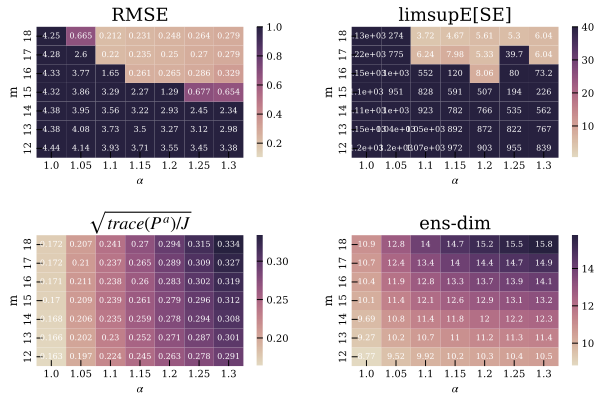

In [32]:
plt.rcParams['text.usetex'] = False # 場当たり的な対応
import seaborn as sns
cmap = "flare" # flare_r
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
fig, ax = plt.subplots(2, 2, figsize=(9, 6))

ax00 = ax[0, 1]
sns.heatmap(df_limsupE_se, ax=ax00, vmax=J*r**2, vmin=J*r**2/100, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax00.set_title("limsupE[SE]")
ax00.set_ylabel("m")
ax00.set_xlabel(r"$ \alpha $")
ax00.invert_yaxis()

ax01 = ax[0, 0]
sns.heatmap(df_rmse, ax=ax01, vmax=r, vmin=r/10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax01.set_title("RMSE")
ax01.set_ylabel("m")
ax01.set_xlabel(r"$ \alpha $")
ax01.invert_yaxis()

ax10 = ax[1, 0]
sns.heatmap(df_traceP, ax=ax10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax10.set_title(r"$\sqrt{trace(P^a)/J}$")
ax10.set_ylabel("m")
ax10.set_xlabel(r"$ \alpha $")
ax10.invert_yaxis()

ax11 = ax[1, 1]
sns.heatmap(df_ensdim, ax=ax11, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
ax11.set_title("ens-dim")
ax11.set_ylabel("m")
ax11.set_xlabel(r"$ \alpha $")
ax11.invert_yaxis()

fig.tight_layout()
fig.savefig(f"{data_dir}/index.pdf")

plt.show()


# if df_rmse.shape[0] > 1 and df_rmse.shape[1] > 1:
#     fig2, ax2 = plt.subplots(1, 2, figsize=(8, 3))
#     ax21 = ax2[0]
#     cf = ax21.contourf(df_rmse.columns, df_rmse.index, df_rmse, levels=[*np.linspace(r/10, r, 50)])
#     plt.colorbar(cf)
#     cs = ax21.contour(df_rmse.columns, df_rmse.index, df_ensdim, cmap="flare_r", levels=np.arange(10, 15, 0.5))
#     ax21.clabel(cs, cs.levels[1::2])
#     ax21.set_xlabel("$ \\alpha $")
#     ax21.set_ylabel("$ m $")
#     ax21.set_title("RMSE with ensemble-dim.")

#     ax22 = ax2[1]
#     cf = ax22.contourf(df_rmse.columns, df_rmse.index, df_rmse, levels=[*np.linspace(r/10, r, 50)])
#     plt.colorbar(cf)
#     cs = ax22.contour(df_rmse.columns, df_rmse.index, df_traceP, cmap="flare_r", levels=np.linspace(r/10, r*3/10, 10))
#     ax22.clabel(cs, cs.levels[1::2])
#     ax22.set_xlabel("$ \\alpha $")
#     ax22.set_ylabel("$ m $")
#     ax22.set_title("RMSE with trace(P).")
#     fig2.tight_layout()


# if df_limsupE_se.shape[0] > 1 and df_limsupE_se.shape[1] > 1:
#     fig3, ax3 = plt.subplots(1, 2, figsize=(8, 3))
#     ax31 = ax3[0]
#     # sns.heatmap(df_limsupE_se, ax=ax31, vmax=J*r**2, vmin=J*r**2/10, cmap=cmap, annot=True, fmt=".3g", annot_kws={'fontsize': 8, 'color':'white'})
#     cf = ax31.contourf(df_limsupE_se.columns, df_limsupE_se.index, df_limsupE_se, levels=[*np.linspace(J*r**2/100, J*r**2, 50)])
#     plt.colorbar(cf)
#     cs = ax31.contour(df_limsupE_se.columns, df_limsupE_se.index, df_ensdim, cmap="flare_r", levels=np.arange(10, 15, 0.5))
#     ax31.clabel(cs, cs.levels[1::2])
#     ax31.set_xlabel("$ \\alpha $")
#     ax31.set_ylabel("$ m $")
#     ax31.set_title("limsupE[SE] with ensemble-dim.")

#     ax32 = ax3[1]
#     cf = ax32.contourf(df_limsupE_se.columns, df_limsupE_se.index, df_limsupE_se, levels=[*np.linspace(J*r**2/100, J*r**2, 50)])
#     plt.colorbar(cf)
#     cs = ax32.contour(df_limsupE_se.columns, df_limsupE_se.index, df_traceP, cmap="flare_r", levels=np.linspace(r/10, r*3/10, 10))
#     ax32.clabel(cs, cs.levels[1::2])
#     ax32.set_xlabel("$ \\alpha $")
#     ax32.set_ylabel("$ m $")
#     ax32.set_title("limsupE[SE] with trace(P).")
#     fig3.tight_layout()

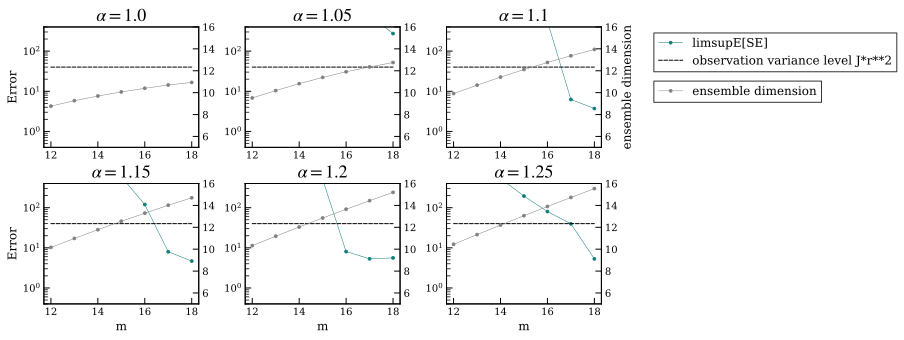

In [21]:
# Dependency on m and alpha
n_row, n_col = 2, 3
fig, ax = plt.subplots(n_row, n_col, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(n_row):
    for j in range(n_col):
        idx = n_col*i + j
        if n_col == 1 and n_row == 1:
            ax1 = ax
        elif n_col == 1 or n_row == 1:
            ax1 = ax[idx]
        else:
            ax1 = ax[i, j]
        ax2 = ax1.twinx()
        alpha = alpha_list[idx]
        ax1.set_title(f"$\\alpha={alpha}$")
        df_limsupE_se[alpha].plot.line(ax=ax1, marker="o", label="limsupE[SE]")
        # df_rmse[alpha].plot.line(ax=ax1, marker="o", label="RMSE")
        ax1.plot(m_reduced_list, J*r**2*np.ones_like(m_reduced_list), lw=1, c="black", ls="--", label="observation variance level J*r**2")
        
        df_ensdim[alpha].plot.line(ax=ax2, marker="o", label="ensemble dimension", color="grey")
        # df_traceP[alpha].plot.line(ax=ax1, marker="o", label="trace(P)", color="black")
            
        ax1.set_ylim([J*r**2/100, 10*J*r**2])
        ax1.set_yscale("log")
        if j==0:
            ax1.set_ylabel("Error")
        if i==n_row-1:
            ax1.set_xlabel("m")

        ax2.set_ylim([5, 16]) # TODO: scale Error J*r**2 equivalent to ensemble dimension 13
        if i==0 and j==n_col-1:
            ax2.set_ylabel("ensemble dimension")
            ax1.legend(bbox_to_anchor=(1.3, 1), loc='upper left')
            ax2.legend(bbox_to_anchor=(1.3, 0.6), loc='upper left')
        


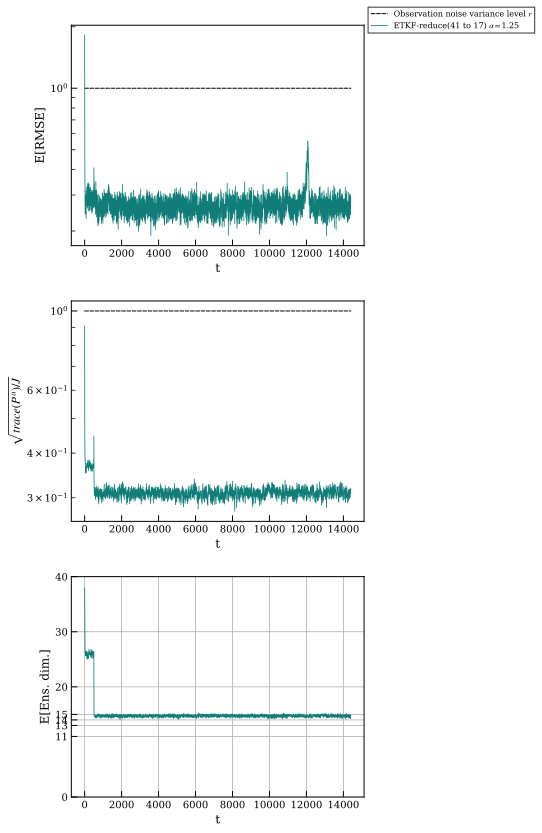

In [44]:
# Plot time series
# Require: Xa_dict

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
fig.subplots_adjust(hspace=0.1)
ax0, ax1, ax2 = ax
plot_type = "expectation" # "one sample", "all sample", "expectation"

# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax0, label='obs.', lw=0.5, color="k", ls="-")
plot_per = 1
t = np.arange(0, len(x_true))[::plot_per]

ax0.plot(t, r*np.ones_like(t), lw=1, c="black", ls="--", label="Observation noise variance level $ r $")
ax1.plot(t, r*np.ones_like(t), lw=1, c="black", ls="--")

i_alpha = 5
if plot_type == "one sample":
     k_seed = 0 # seed
     print("k_seed", k_seed)
for i in range(len(m_reduced_list)):
    if i != 5:
        continue
    for j in [i_alpha]:
        m_reduced, alpha, _ = param_dict[i, j, k]

        # ax0
        match plot_type:
            case "one sample":
                # plot rmse for seed k
                k = k_seed
                xa = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                plot_loss(x_true[::plot_per], xa[::plot_per], loss_rms, x_index=t, ax=ax0, label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
            case "all sample":
                # plot rmse samples over seeds
                for k in range(len(seeds)):
                    xa_k = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                    plot_loss(x_true[::plot_per], xa_k, loss_rms, x_index=t, ax=ax0, lw=0.3, alpha=0.5)
            case "expectation":
                # plot E[rmse]
                rmse_wt = []
                for k in range(len(seeds)):
                    xa_k = [np.mean(X, axis=0) for X in Xa_dict[i, j, k]]
                    rmse_k = np.linalg.norm(x_true-xa_k, axis=-1)/np.sqrt(J)
                    rmse_wt.append(rmse_k) # (N_seed, T)
                rmse_t = np.mean(np.array(rmse_wt), axis=0) # (T, )
                ax0.plot(t, rmse_t, label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        
        # ax1
        match plot_type:
            case "one sample":
                k = k_seed
                ax1.plot(t, np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)[::plot_per], label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
            case "all sample":
                for k in range(len(seeds)):
                    ax1.plot(t, np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)[::plot_per], lw=0.3, alpha=0.5)
            case "expectation":
                traceP_wt = []
                for k in range(len(seeds)):
                    traceP_k = np.sqrt(compute_traceP(Xa_dict[i, j, k])/J)
                    traceP_wt.append(traceP_k)
                traceP_t = np.mean(np.array(traceP_wt), axis=0)
                ax1.plot(t, traceP_t, label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        # plot_loss((H@x_true[::plot_per].T).T, y[::plot_per], loss_rms, x_index=t, ax=ax1, label='obs.', lw=0.5, color="black", ls="-")
# 
        # ax1.legend(bbox_to_anchor=(1, 1.1), loc="upper left")

        # ax2
        match plot_type:
            case "one sample":
                k = k_seed
                ax2.plot(compute_edims(Xa_dict[i, j, k])[::plot_per], label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
            case "all sample":
                for k in range(len(seeds)):
                    ax2.plot(compute_edims(Xa_dict[i, j, k])[::plot_per], lw=0.3, alpha=0.5)
            case "expectation":
                edims_wt = []
                for k in range(len(seeds)):
                    edims_k = compute_edims(Xa_dict[i, j, k])
                    edims_wt.append(edims_k)
                edims_t = np.mean(np.array(edims_wt), axis=0)
                ax2.plot(edims_t, label=f'ETKF-reduce({m} to {m_reduced}) $ \\alpha=${alpha}', lw=0.8)
        ax2.set_xlabel('t')
        ax2.set_ylabel('Ens. dim.')
        # ax2.set_ylim([10, 20])
        ax2.set_yticks([0, 11, 13, 14, 15, 20, 30, 40])
        # ax2.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
        # arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
        # print(f"reduce ensemble at {N_spinup}")

# ax0
ax0.set_xlabel('t')
if plot_type == "expectation":
    ax0.set_ylabel('E[RMSE]')
else:
    ax0.set_ylabel('RMSE')
ax0.legend(bbox_to_anchor=(1, 1.1), loc="upper left", fontsize=8)
ax0.set_yscale("log")
fig.tight_layout()

# ax1
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\sqrt{trace(P^a)/J}$')
ax1.set_yscale('log')

# ax2
ax2.set_xlabel('t')
if plot_type == "expectation":
    ax2.set_ylabel('E[Ens. dim.]')
else:
    ax2.set_ylabel('Ens. dim.')
ax2.grid(True)


fig.tight_layout()



# Plot
# for i, m_reduced in enumerate(m_reduced_list):
#     plot_loss(x_true, etkf_list[i].x, loss_rms, ax=ax0, label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     plot_loss(x_true, etkf0_list[i].x, loss_rms, ax=ax0, label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax0, label='obs.', lw=0.5, color="k", ls="-")
# ax0.set_xlabel('t')
# ax0.set_ylabel('RMSE')
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# # ax0.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax0.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# ax0.set_ylim([0, 2])


# ax1 = ax[1]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax1.plot(np.sqrt(compute_traceP(etkf_list[i].X_a)/J), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax1.plot(np.sqrt(traceP(etkf0_list[i].X_a)/J), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax1, label='obs.', lw=0.5, color="k", ls="-")
# ax1.set_xlabel('t')
# ax1.set_ylabel(r'$\sqrt{trace(P^a)/J}$')
# ax1.set_yscale('log')
# ax1.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)

# X_a = etkf_list[-1].X_a
# print(etkf_list[-1].m)

# ax2 = ax[2]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax2.plot(compute_edims(etkf_list[i].X_a), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax2.plot(compute_edims(etkf0_list[i].X_a), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# ax2.set_xlabel('t')
# ax2.set_ylabel('Ens. dim.')
# # ax2.set_ylim([10, 20])
# ax2.set_yticks([0, 11, 13, 15, 20, 30, 40])
# ax2.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# print(f"reduce ensemble at {N_spinup}")
# # ax.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# # ax.set_ylim([0, 2])
# # ax.set_yscale("log")
# fig.tight_layout()
# plt.grid(True)
# fig.tight_layout()

In [166]:
# Plot
# for i, m_reduced in enumerate(m_reduced_list):
#     plot_loss(x_true, etkf_list[i].x, loss_rms, ax=ax0, label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     plot_loss(x_true, etkf0_list[i].x, loss_rms, ax=ax0, label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax0, label='obs.', lw=0.5, color="k", ls="-")
# ax0.set_xlabel('t')
# ax0.set_ylabel('RMSE')
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# # ax0.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax0.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# ax0.set_ylim([0, 2])
# ax0.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# ax0.set_yscale("log")
# fig.tight_layout()

# ax1 = ax[1]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax1.plot(np.sqrt(compute_traceP(etkf_list[i].X_a)/J), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax1.plot(np.sqrt(traceP(etkf0_list[i].X_a)/J), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# plot_loss((H@x_true.T).T, y, loss_rms, ax=ax1, label='obs.', lw=0.5, color="k", ls="-")
# ax1.set_xlabel('t')
# ax1.set_ylabel(r'$\sqrt{trace(P^a)/J}$')
# ax1.set_yscale('log')
# ax1.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)

# X_a = etkf_list[-1].X_a
# print(etkf_list[-1].m)

# ax2 = ax[2]
# for i, m_reduced in enumerate(m_reduced_list):
#     ax2.plot(compute_edims(etkf_list[i].X_a), label=f'ETKF-reduce({m} to {m_reduced})', lw=0.8)
# # for i, m_reduced in enumerate(m_reduced_list):
# #     ax2.plot(compute_edims(etkf0_list[i].X_a), label=f'ETKF-{m_reduced}', lw=0.8, ls="--")
# ax2.set_xlabel('t')
# ax2.set_ylabel('Ens. dim.')
# # ax2.set_ylim([10, 20])
# ax2.set_yticks([0, 11, 13, 15, 20, 30, 40])
# ax2.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
# arrow_style = dict(facecolor='black', shrink=0.01, width=0.3, headlength=5, headwidth=5)
# print(f"reduce ensemble at {N_spinup}")
# # ax.annotate('', xy=(N_spinup, 1.5*r), xytext=(N_spinup, 2*r), arrowprops=arrow_style)
# # ax.text(N_spinup-30, 2*r, 'reduce ensemble', fontdict=dict(fontsize=12))
# # ax.set_ylim([0, 2])
# # ax.set_yscale("log")
# fig.tight_layout()
# plt.grid(True)
# fig.tight_layout()

## loop r

In [202]:
data_dir_r = "data/reduced_ens/r{}"

logr_list = [0, 1, 2, 3, 4]

# load params
set_params = load_module(data_dir_r.format(0))
m_reduced_list = set_params.m_reduced_list

rmse_r = np.zeros((len(logr_list), len(m_reduced_list)))
limsupE_se_r = np.zeros((len(logr_list), len(m_reduced_list)))
for i, logr in enumerate(logr_list):
    dir = data_dir_r.format(logr)
    print(dir)

    # load params
    set_params = load_module(dir)

    # load data
    df_rmse = pd.read_csv(dir + "/rmse.csv", index_col=0, header=0)
    df_limsupE_se = pd.read_csv(dir + "/limsupE_se.csv", index_col=0, header=0)
    # print(df_limsupE_se)

    # optimal for each m
    rmse_opt = df_rmse.to_numpy().min(axis=1) # (len(m_reduced_list), )
    limsupE_se_opt = df_limsupE_se.to_numpy().min(axis=1) # (len(m_reduced_list), )
    rmse_r[i] = rmse_opt
    limsupE_se_r[i] = limsupE_se_opt

data/reduced_ens/r0
data/reduced_ens/r1
data/reduced_ens/r2
data/reduced_ens/r3
data/reduced_ens/r4


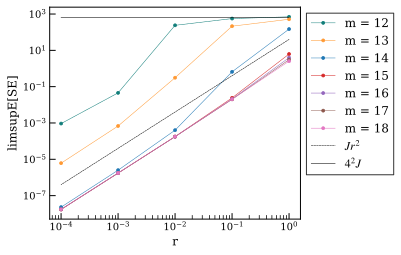

In [208]:
fig = plt.figure(figsize=(6, 4))
for i, m in enumerate(m_reduced_list):
    plt.plot(0.1**(np.array(logr_list)), limsupE_se_r[:, i], label=f"m = {m}", marker="o") 
plt.plot(0.1**(np.array(logr_list)), J*0.01**(np.array(logr_list)), color="black", ls="--", label="$Jr^2$")  
plt.plot(0.1**(np.array(logr_list)), J*16*np.ones_like(logr_list), color="black", ls="-", label="$4^2 J$")  
plt.xscale("log")
plt.yscale("log")
plt.xlabel("r")
plt.ylabel("limsupE[SE]")
plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.savefig(f"data/reduced_ens/limsupE_se_r.pdf")